# 项目背景

电子商务网站常常涉及大额资金交易。大额资金的流动往往伴随着用户从事欺诈活动的高风险，例如使用盗窃的信用卡、洗钱等。机器学习在识别欺诈活动方面表现出色。几乎所有输入信用卡信息的网站都有风控团队通过机器学习来避免欺诈行为。此挑战的目标是构建一个机器学习模型，预测新用户的首次交易是否具有高欺诈概率。

XYZ公司是一个销售手工制衣的电子商务网站。你需要构建一个模型，预测用户是否有使用该网站进行非法活动的高概率。这是数据科学家常见的任务之一。你只能获取用户在网站上的首次交易信息，基于这些信息进行分类（“欺诈/非欺诈”）。以下是你需要完成的任务：

1. 根据用户的数值IP地址确定其国家。
2. 构建模型预测活动是否为欺诈。解释不同假设关于误报成本与漏报成本如何影响模型。
3. 你的上司担心使用她不理解的模型来做重要的欺诈检测。你将如何向她解释模型是如何做出预测的？不需要从数学角度（她不关心这些），而是从用户角度解释。哪些类型的用户更可能被分类为风险用户？他们有什么特征？
4. 假设你现在有了这个可以实时预测活动是否欺诈的模型。从产品角度，你将如何使用它？即，你会根据模型输出构建什么样的不同用户体验？

# 导入数据集

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

接着导入两个数据集：

In [2]:
fraud_data = pd.read_csv("./../dataset/04. Fraud_Data.csv")

In [3]:
ip_data = pd.read_csv("./../dataset/IpAddress_to_Country.csv")

简单的查看一下这两个数据集：

In [4]:
fraud_data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


In [5]:
ip_data.head()

,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China
3,16778240.0,16779263,Australia
4,16779264.0,16781311,China


这个数据集显然用于关联IP地址和国家。每一行包含一个IP地址范围（lower_bound_ip_address 和 upper_bound_ip_address）和与这个范围对应的国家（country）。这种数据通常用于地理定位服务，以确定一个特定的IP地址属于哪个国家。在处理网站访问、安全监控、定向广告等需要地理信息的场景中，这种数据非常有用。例如，如果你有一个用户的IP地址，你可以使用这个数据集来查找这个IP地址所在的国家，从而进行进一步的数据分析或业务决策。

同一个国家会有多个不同的IP范围，主要是因为：

1. **多个服务提供商**: 不同的互联网服务提供商（ISP）可能在同一个国家内操作，每个提供商都被分配了不同的IP地址块。
2. **IP地址的重新分配**: 随着时间的推移，IP地址可能会重新分配给不同的服务或地区以满足需求变化。
3. **网络扩展和再结构**: 随着网络的扩展和重组，新的IP范围可能会创建，旧的IP范围可能会被修改或细分。

这样的安排允许更有效地管理和优化网络资源，并处理地理位置和技术需求的变化。

# EDA

首先查看一下fraud_data中的一些特征的分布情况：

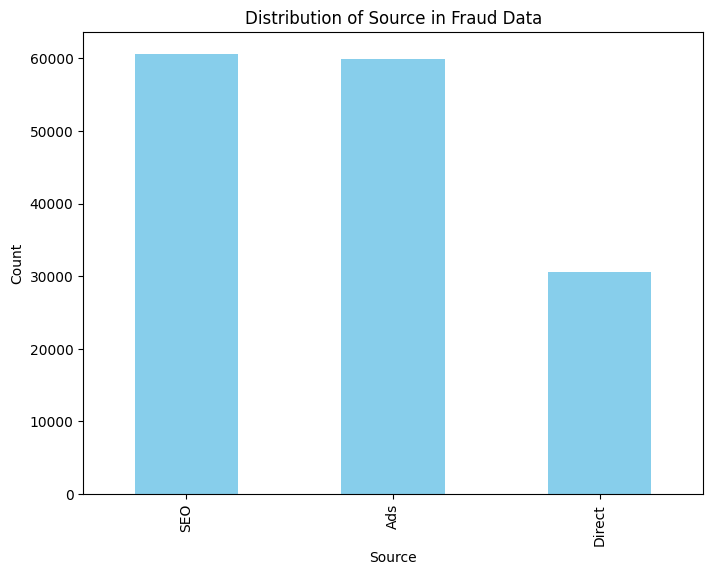

In [6]:
# 统计fraud_data中的source特征的不同值各自的总数
source_counts = fraud_data['source'].value_counts()
# 接着创建bar chart
plt.figure(figsize = (8, 6))
source_counts.plot(kind = 'bar', color = 'skyblue')
plt.title('Distribution of Source in Fraud Data')
plt.xlabel('Source')
plt.ylabel('Count')
plt.show()

可以发现大部分的用户都是通过SEO或者Ads作为来源的,只有极少数的用户是通过Direct作为来源的。

接着查看用户的purchase value的值的分布：

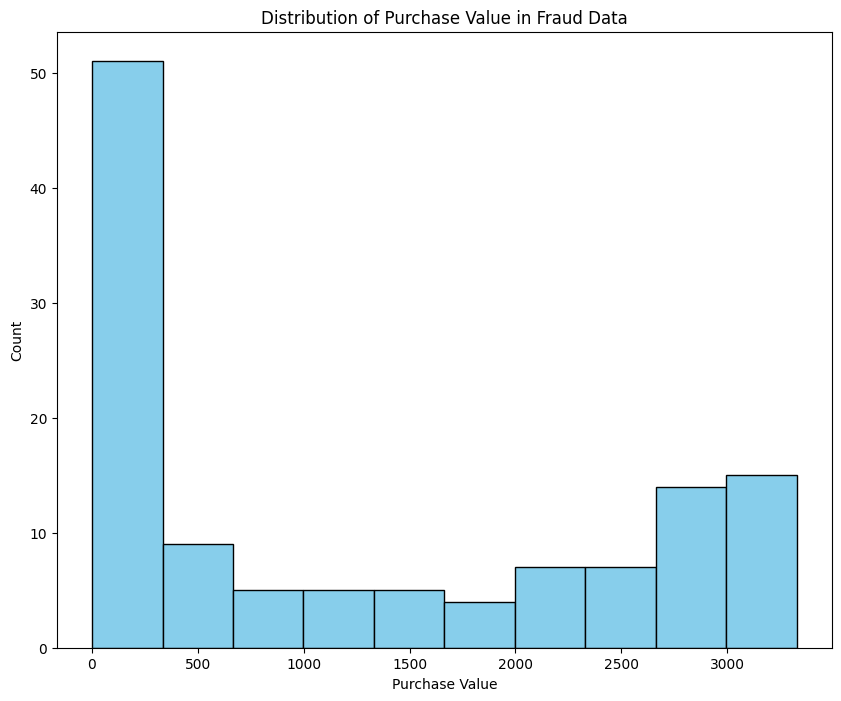

In [7]:
# 统计fraud_data中的purchase value特征的不同值各自的总数
purchase_counts = fraud_data['purchase_value'].value_counts()
# 接着创建bar chart
plt.figure(figsize = (10, 8))
purchase_counts.plot(kind = 'hist', color = 'skyblue', edgecolor='black')
plt.title('Distribution of Purchase Value in Fraud Data')
plt.xlabel('Purchase Value')
plt.ylabel('Count')
plt.show()

这个图表显示了“购买价值”在欺诈数据中的分布。从图表可以看出：

1. **集中在低值区域**：大部分购买价值集中在非常低的价值区域，特别是在0到500的区间内，这一区间的频数最高。
2. **长尾分布**：随着购买价值的增加，频数逐渐减少，呈现出典型的长尾分布特征。这意味着较高的购买价值出现的次数较少。
3. **一些中间峰值**：在大约2500和3000的购买价值区域，出现了频数的小幅回升，这可能表明某些特定价值点上有集中的购买行为。

这种分布可能对理解欺诈行为的特点有一定的帮助，例如，低价值的交易可能是欺诈者用来测试信用卡有效性的常用策略，而较高价值的集中可能指示了特定的高风险行为模式。

同样的,我们可以查看一下browser的分布情况:

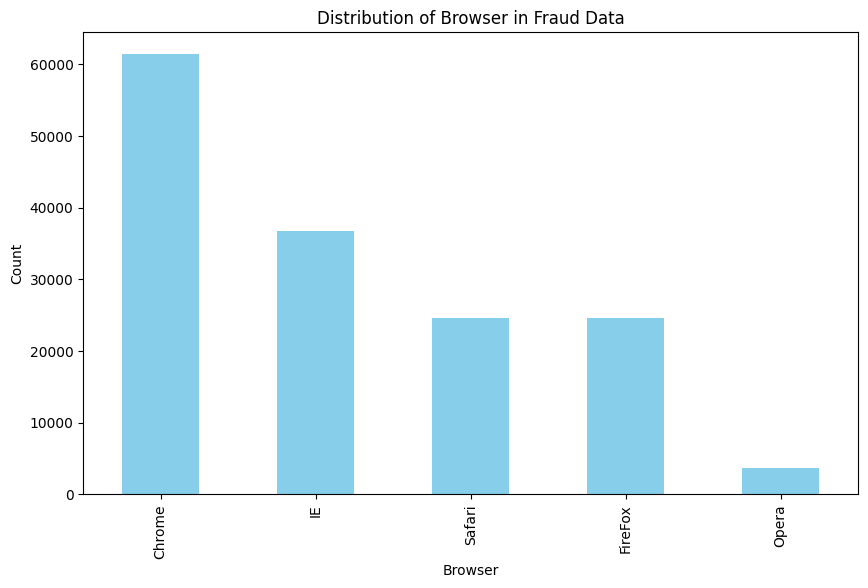

In [8]:
# Assuming 'fraud_data' is your DataFrame and it has a column named 'source'
# First, calculate the counts of each source category
browser_counts = fraud_data['browser'].value_counts()

# Now, create a bar chart
plt.figure(figsize=(10, 6))
browser_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of Browser in Fraud Data')
plt.xlabel('Browser')
plt.ylabel('Count')
plt.show()

这张图表显示了欺诈数据中使用不同浏览器的分布情况。从图中可以看出：

- **Chrome** 是最常用的浏览器，使用人数超过了60,000，明显高于其他浏览器。
- **IE（Internet Explorer）** 也相对常用，使用人数约为40,000。
- **Safari** 和 **Firefox** 的使用人数较为接近，都在20,000到30,000之间。
- **Opera** 的使用人数最少，远低于其他选项，表明其在数据集中的用户相对较少。

这种分布可能反映了不同浏览器用户群体在数据集中的代表性或者在特定浏览器上欺诈活动的发生率。例如，Chrome和IE的高使用率可能与它们的广泛普及有关，也可能表明这些浏览器更容易被欺诈活动利用。这样的信息对于分析浏览器安全性和制定防欺诈措施可能非常有用。

接着查看一下sex的分布情况:

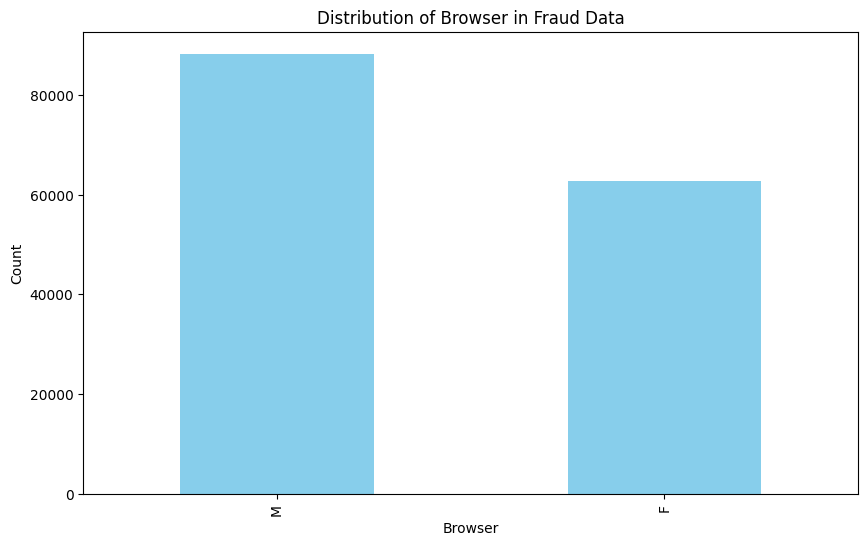

In [9]:
# Assuming 'fraud_data' is your DataFrame and it has a column named 'source'
# First, calculate the counts of each source category
sex_counts = fraud_data['sex'].value_counts()

# Now, create a bar chart
plt.figure(figsize=(10, 6))
sex_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of Browser in Fraud Data')
plt.xlabel('Browser')
plt.ylabel('Count')
plt.show()

可以发现主要数据集中性别主要为男性,其次是女性,但是两者的差距并不是非常大,并没有呈现出明显的不均衡。

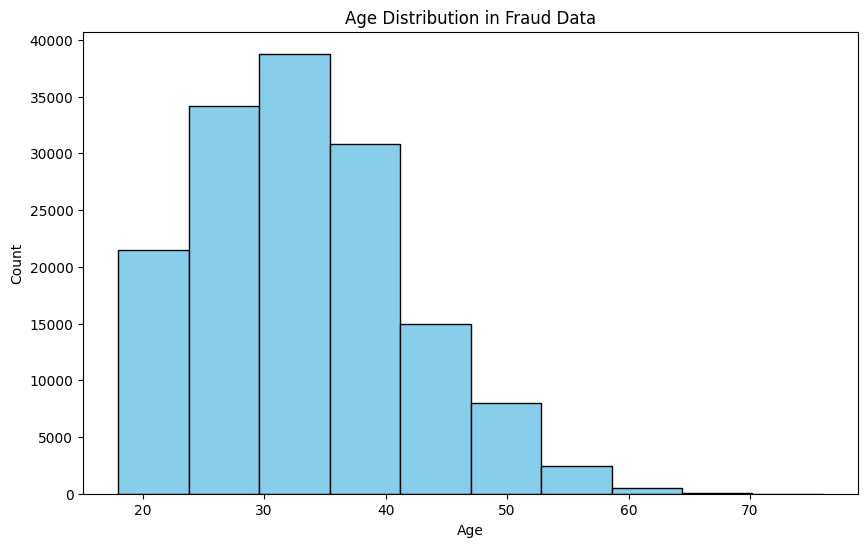

In [10]:
# 统计fraud_data中的purchase value特征的不同值各自的总数
plt.figure(figsize=(10, 6))
plt.hist(fraud_data['age'], bins=10, color='skyblue', edgecolor='black')
plt.title('Age Distribution in Fraud Data')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

从可视化的结果可以看出,年龄变量接近于正态分布,或者可以认为存在着略微的右偏态分布。

最重要的是查看一下target变量的分布情况：

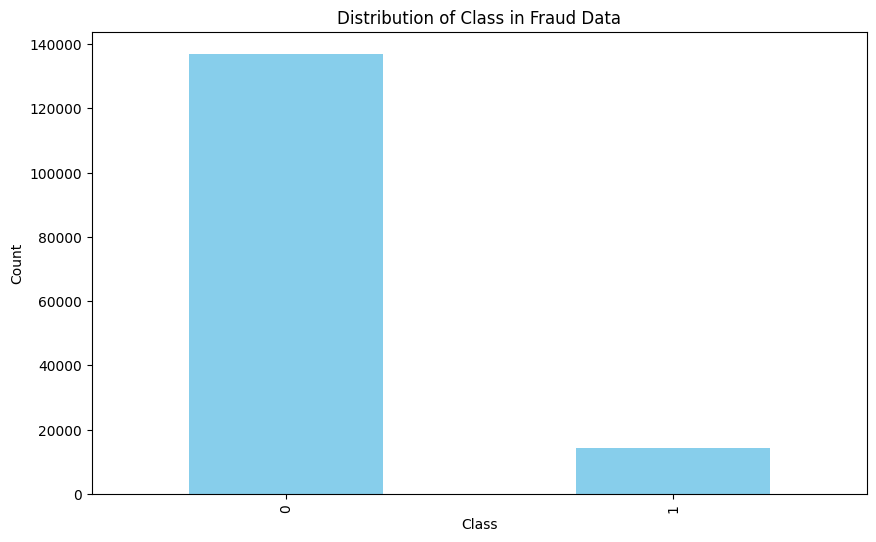

In [11]:
class_counts = fraud_data['class'].value_counts()

# Now, create a bar chart
plt.figure(figsize=(10, 6))
class_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of Class in Fraud Data')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

In [12]:
class_counts[1] / class_counts[0]

0.10332138345952498

这张图表显示了欺诈数据中“class”变量的分布，即图中展示了类别 `0`（非欺诈）和类别 `1`（欺诈）的计数。

从图表可以看出：

- **类别 `0`（非欺诈）的数量远远超过类别 `1`（欺诈）**，这表明数据集中大多数的交易或行为是正常的，而欺诈行为相对较少。
- **类别 `0` 的计数接近140,000，而类别 `1` 的计数大约20,000**，这种比例差异可能对使用机器学习模型进行训练时造成影响，因为类别不平衡可能导致模型偏向于预测多数类。

这种可视化有助于快速识别数据中的潜在偏差或需要特别关注的地方，比如可能需要考虑采取一些技术手段来处理类别不平衡问题，以提高模型对少数类（即欺诈）的识别能力。

# 特征工程

接着通过第二个数据集来给第一个数据集添加一个country特征。

首先使用一个例子来进行尝试：

In [13]:
# 使用loc来获得第2行的ip_address变量数据
ip_address = fraud_data.loc[2, 'ip_address']
# 然后通过列表内推到来获得ip_data中lower_bound_ip_address在这个ip_address的数据
tmp = ip_data[(ip_data['lower_bound_ip_address'] <= ip_address) & (ip_data['upper_bound_ip_address'] >= ip_address)]

In [14]:
tmp

,lower_bound_ip_address,upper_bound_ip_address,country
43965,2.621440e+09,2621505535,United States


如果我们直接使用：

In [15]:
tmp['country']

43965    United States
Name: country, dtype: object

则会得到一个包含索引的结果。

因此需要使用.values[]来进行访问：

In [16]:
tmp['country'].values[0]

'United States'

因为.values[]得到的结果只包含值但是不包含索引。

In [17]:
# 首先创建一个空列表
countries = []

# 接着开始进行遍历
for i in range(len(fraud_data)):
    # 对每一行的数据,只提取出来ip_address数据
    ip_address = fraud_data.loc[i, 'ip_address']
    # print(ip_address)
    tmp = ip_data[(ip_data['lower_bound_ip_address'] <= ip_address) & (ip_data['upper_bound_ip_address'] >= ip_address)]
    # 需要考虑可能不存在这个ip address记录的情况
    if len(tmp) == 1:
        countries.append(tmp['country'].values[0])
    else:
        countries.append('NA')

In [18]:
# 接着在数据集中添加这个特征
fraud_data['country'] = countries

然后查看一下fraud_data现在的情况:

In [19]:
fraud_data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,NA
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States


In [20]:
# 将"NAN"和"NA"都视为缺失值
fraud_data.replace({"NAN": np.nan, "NA": np.nan}, inplace=True)

# 计算每个特征的缺失值数量
missing_values_count = fraud_data.isnull().sum()

# 计算数据集的总行数
total_rows = fraud_data.shape[0]

# 计算每个特征的缺失值百分比
missing_values_percentage = (missing_values_count / total_rows) * 100

# 打印每个特征的缺失值百分比
print(missing_values_percentage)

user_id            0.000000
signup_time        0.000000
purchase_time      0.000000
purchase_value     0.000000
device_id          0.000000
source             0.000000
browser            0.000000
sex                0.000000
age                0.000000
ip_address         0.000000
class              0.000000
country           14.536238
dtype: float64


只有country包含了缺失值，但是占比只有14.5%左右，这里采用直接删除的方式来处理：

In [21]:
# 删除包含缺失值的行
fraud_data_cleaned = fraud_data.dropna()

# 打印清理后的数据集的大小，以确认缺失值已被删除
print(f"Original data shape: {fraud_data.shape}")
print(f"Cleaned data shape: {fraud_data_cleaned.shape}")

Original data shape: (151112, 12)
Cleaned data shape: (129146, 12)


基于现有的特征，我们还可以生成一些新的特征变量。

首先是从注册到购买的时间差：

In [22]:
# 将时间列从字符串转换为datetime对象
fraud_data['signup_time'] = pd.to_datetime(fraud_data['signup_time'])
fraud_data['purchase_time'] = pd.to_datetime(fraud_data['purchase_time'])

# 计算时间差
time_diff = fraud_data['purchase_time'] - fraud_data['signup_time']

# 使用.apply(lambda x: x.seconds)来获取时间差的秒数
time_diff = time_diff.apply(lambda x: x.seconds)

# 将结果添加到数据框
fraud_data['time_diff'] = time_diff

然后是device_id是否是独特的：

In [23]:
# Check user number for unique devices
device_num = fraud_data[['user_id', 'device_id']].groupby('device_id').count().reset_index()
device_num = device_num.rename(columns={'user_id': 'device_num'})
fraud_data = fraud_data.merge(device_num, how='left', on='device_id')

同样的，我们也可以考察ip地址是否是独立的：

In [24]:
# Check user number for unique ip_address
ip_num = fraud_data[['user_id', 'ip_address']].groupby('ip_address').count().reset_index()
ip_num = ip_num.rename(columns={'user_id': 'ip_num'})
fraud_data = fraud_data.merge(ip_num, how='left', on='ip_address')

另外对于时间特征，我们还可以生成日和周特征：

In [25]:
# Signup day and week
fraud_data['signup_day'] = fraud_data['signup_time'].apply(lambda x: x.dayofweek)
fraud_data['signup_week'] = fraud_data['signup_time'].apply(lambda x: x.week)

# Purchase day and week
fraud_data['purchase_day'] = fraud_data['purchase_time'].apply(lambda x: x.dayofweek)
fraud_data['purchase_week'] = fraud_data['purchase_time'].apply(lambda x: x.week)

查看一下现在的数据集情况：

In [26]:
fraud_data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,time_diff,device_num,ip_num,signup_day,signup_week,purchase_day,purchase_week
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,13882,1,1,1,9,5,16
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,17944,1,1,6,23,0,24
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,1,12,12,3,1,3,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,NaN,60085,1,1,1,18,0,19
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States,41461,1,1,1,30,2,37


使用哪些特征来创建模型。

In [27]:
# 导入信用卡库
import scorecardpy as sc

In [28]:
# 计算所有特征的IV值
iv_table = sc.iv(fraud_data, y='class')

查看一下每个特征的具体的信息值：

In [29]:
# iv_table 是一个DataFrame，包含特征名称和它们的IV值
print(iv_table)

          variable  info_value
5       device_num    3.356504
16   purchase_week    3.207378
9           ip_num    2.907351
0      signup_week    1.497971
7        time_diff    1.221354
4        device_id    0.148255
17      ip_address    0.126618
11         country    0.057002
10  purchase_value    0.036762
6              age    0.019470
15      signup_day    0.013825
8     purchase_day    0.012200
1    purchase_time    0.005647
13          source    0.004886
12     signup_time    0.003772
2          user_id    0.003772
14         browser    0.003499
3              sex    0.000690


IV值的解释通常遵循这样的规则：

- IV < 0.02: 特征几乎无预测能力。
- 0.02 <= IV < 0.1: 特征具有弱预测能力。
- 0.1 <= IV < 0.3: 特征具有中等预测能力。
- 0.3 <= IV < 0.5: 特征具有较强的预测能力。
- IV >= 0.5: 特征具有非常强的预测能力。

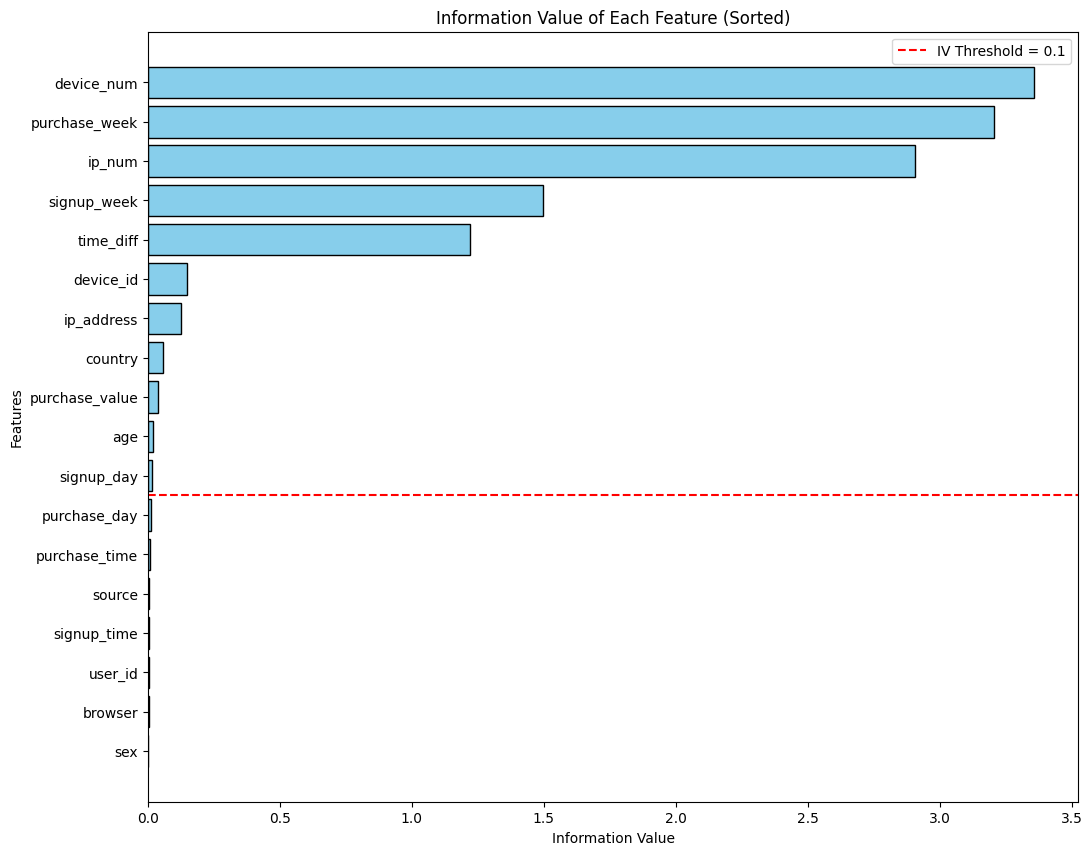

In [30]:
iv_table_sorted = iv_table.sort_values(by='info_value', ascending=True)

# 绘制条形图
plt.figure(figsize=(12, 10))
plt.barh(iv_table_sorted.variable, iv_table_sorted.info_value, color='skyblue', edgecolor='black')
plt.title('Information Value of Each Feature (Sorted)')
plt.xlabel('Information Value')
plt.ylabel('Features')

# 在IV=0.1处添加水平虚线，区分高低信息价值
threshold_index = sum(iv_table_sorted.info_value >= 0.1) - 0.5  # 计算阈值线位置
plt.axhline(y=threshold_index, color='red', linestyle='--', label='IV Threshold = 0.1')
plt.legend()

plt.show()

根据您提供的信息价值（IV）表，IV值通常被用作衡量特征预测能力的指标。这里使用0.1作为基准线来判定特征是否具有足够的预测力。基于此标准，可以将特征分为两类：

**需要保留的特征**

1. **device_num** - IV = 3.356504：具有非常强的预测能力。
2. **purchase_week** - IV = 3.207378：具有非常强的预测能力。
3. **ip_num** - IV = 2.907351：具有非常强的预测能力。
4. **signup_week** - IV = 1.497971：具有较强的预测能力。
5. **time_diff** - IV = 1.221354：具有较强的预测能力。

这些特征的IV值远远高于0.1，表明它们在区分目标变量（如区分欺诈与非欺诈行为）上具有较强的预测能力。它们可以被视为模型中的重要变量，并应该被包括在任何预测模型中。

**可能不需要保留的特征**

1. **device_id** - IV = 0.148255：具有一定的预测能力，但相对较弱。
2. **ip_address** - IV = 0.126618：具有一定的预测能力，但相对较弱。

这两个特征的IV值略高于0.1，表明它们具有一定的预测能力，但效果可能不如上述特征显著。在资源有限或模型简化需求的情况下，可以考虑从模型中排除这些特征。

**预测能力非常弱的特征**

1. **country** - IV = 0.057002
2. **purchase_value** - IV = 0.036762
3. **age** - IV = 0.019470
4. **signup_day** - IV = 0.013825
5. **purchase_day** - IV = 0.012200
6. **purchase_time** - IV = 0.005647
7. **source** - IV = 0.004886
8. **signup_time** - IV = 0.003772
9. **user_id** - IV = 0.003772
10. **browser** - IV = 0.003499
11. **sex** - IV = 0.000690

这些特征的IV值远低于0.1，表明它们在预测模型中的贡献可能非常有限。通常情况下，这些特征可以被排除出模型以减少模型复杂度和提高计算效率，特别是在有明显的数据维度限制或者处理能力限制时。

总之，应当重点关注那些IV值高于0.1的特征，并根据具体的建模目的和数据的特性考虑保留或删除IV值低于0.1的特征。

In [31]:
# 过滤出IV值大于0.1的特征
features_to_keep = iv_table[iv_table['info_value'] > 0.1]['variable'].tolist()

In [32]:
features_to_keep

['device_num',
 'purchase_week',
 'ip_num',
 'signup_week',
 'time_diff',
 'device_id',
 'ip_address']

In [33]:
# 添加目标变量 'class' 到列表中
features_to_keep.append('class')

In [34]:
# 从fraud_data中选取这些特征
filtered_data = fraud_data[features_to_keep]

In [35]:
filtered_data.columns

Index(['device_num', 'purchase_week', 'ip_num', 'signup_week', 'time_diff',
       'device_id', 'ip_address', 'class'],
      dtype='object')

可以查看一下特征之间的相关性，因为一些特征是使用另外的一些特征来计算的：

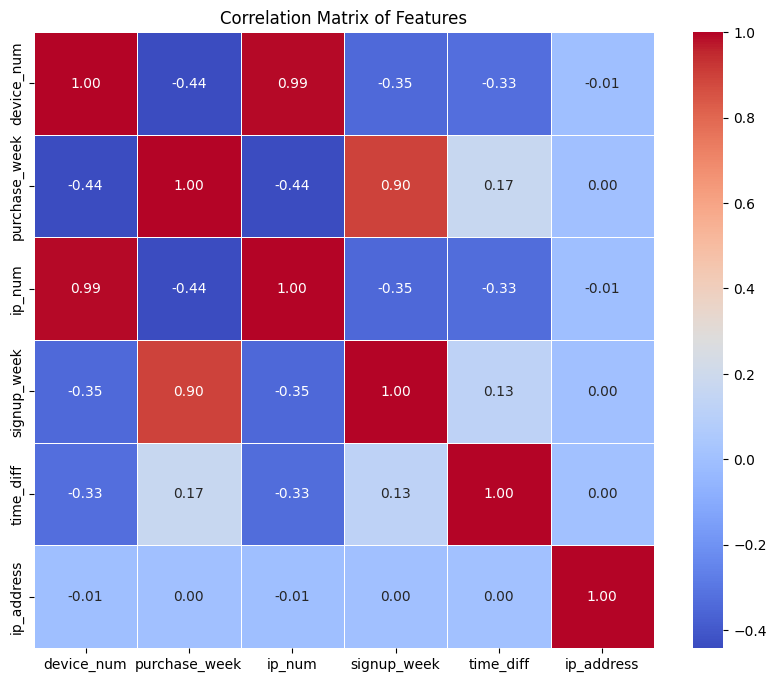

In [36]:
features_data = filtered_data.drop(columns=['class', 'device_id'])

# 计算相关性矩阵
correlation_matrix = features_data.corr()

# 使用 seaborn 创建热图
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, linewidths=0.5)
plt.title('Correlation Matrix of Features')
plt.show()

In [37]:
correlation_matrix

,device_num,purchase_week,ip_num,signup_week,time_diff,ip_address
device_num,1.000000,-0.438412,0.991083,-0.345680,-0.327390,-0.007585
purchase_week,-0.438412,1.000000,-0.442106,0.897286,0.169125,0.002482
ip_num,0.991083,-0.442106,1.000000,-0.348412,-0.331099,-0.006895
signup_week,-0.345680,0.897286,-0.348412,1.000000,0.126157,0.000997
time_diff,-0.327390,0.169125,-0.331099,0.126157,1.000000,0.003827
ip_address,-0.007585,0.002482,-0.006895,0.000997,0.003827,1.000000


device_num 和 ip_num: 相关系数为 0.991083，这表明这两个特征之间有非常强的正相关关系。这可能意味着它们在某种程度上提供了相似的信息。

purchase_week 和 signup_week: 相关系数为 0.897286，这表明这两个特征之间也有很强的正相关关系。这两个特征可能都反映了时间信息的某些方面，可能是在相同或相近的时间段内进行了注册和购买。

每组特征变量只保留一个特征：

In [38]:
filtered_data =  filtered_data.drop(columns=['ip_num', 'signup_week', 'device_id'])

In [39]:
filtered_data.columns

Index(['device_num', 'purchase_week', 'time_diff', 'ip_address', 'class'], dtype='object')

# 决策树模型

**模型训练**

导入必备的库：

In [66]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, recall_score, precision_score, roc_auc_score, roc_curve, auc

准备数据：

In [41]:
# 分离特征和目标变量
X = filtered_data.drop('class', axis=1)
y = filtered_data['class']

# 分割数据为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

训练决策树模型：

In [42]:
# 创建决策树分类器实例
tree_model = DecisionTreeClassifier(random_state=42)

# 训练模型
tree_model.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

评估模型：

In [43]:
# 在测试集上进行预测
y_pred = tree_model.predict(X_test)

# 评估模型
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.9198954438672534
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.95      0.96     27373
           1       0.57      0.59      0.58      2850

    accuracy                           0.92     30223
   macro avg       0.77      0.77      0.77     30223
weighted avg       0.92      0.92      0.92     30223

Confusion Matrix:
 [[26119  1254]
 [ 1167  1683]]


从上述的结果来看，模型在预测class=0（没有欺诈）的性能上表现优秀，当预测一个样本不是欺诈的时候，正确预测的可能性为96%；但是在预测class=1的时候表现得不是非常好，当预测一个样本为欺诈样本的时候，只有57%的可能性确实是欺诈。对于类别0，召回率为 95%，实际上为非欺诈的案例中，有95%被模型正确地识别为非欺诈；对于类别1，召回率为 59%：实际上为欺诈的案例中，有59%被模型正确地识别为欺诈。对于类别0，F1分数为 96%，这是精确度和召回率的调和平均，表示模型在非欺诈类别的整体性能非常好；对于类别1，F1分数为 58%，这表明尽管模型在识别欺诈案例方面有一定能力，但精确度和召回率的平衡还有改进空间。

**调整模型参数**

虽然模型在非欺诈案例的预测上表现出色，但在欺诈案例的识别上还有待提高。尤其是模型的欺诈类别精确度相对较低，这意味着存在较多的假阳性，即非欺诈交易被误判为欺诈。这可能导致不必要的客户干预或调查。增加模型在欺诈类别上的召回率也同样重要，因为这关系到减少漏检，确保欺诈活动被适当标识和处理。
针对欺诈检测，通常更关注提高对欺诈类别的识别能力，特别是在保持可接受的误报率的同时，尽可能捕捉更多真正的欺诈案例。可能的改进策略包括调整模型参数，尝试不同的分类算法，或者进一步优化特征选择和工程。

In [44]:
y_probs = tree_model.predict_proba(X_test)[:, 1]  # 取得类别1的概率

In [45]:
from sklearn.metrics import accuracy_score, recall_score, precision_score

In [46]:
thresholds = np.arange(0.1, 0.9, 0.1)  # 生成多个阈值，从0.1到0.8，步长为0.1
results = []

In [47]:
for thresh in thresholds:
    y_pred_thresh = (y_probs >= thresh).astype(int)  # 根据阈值生成新的预测
    accuracy = accuracy_score(y_test, y_pred_thresh)
    recall = recall_score(y_test, y_pred_thresh)
    precision = precision_score(y_test, y_pred_thresh)
    results.append((thresh, accuracy, recall, precision))

In [48]:
# 打印不同阈值下的性能
for result in results:
    print(f'Threshold: {result[0]}, Accuracy: {result[1]}, Recall: {result[2]}, Precision: {result[3]}')

Threshold: 0.1, Accuracy: 0.9198954438672534, Recall: 0.5905263157894737, Precision: 0.5730337078651685
Threshold: 0.2, Accuracy: 0.9198954438672534, Recall: 0.5905263157894737, Precision: 0.5730337078651685
Threshold: 0.30000000000000004, Accuracy: 0.9198954438672534, Recall: 0.5905263157894737, Precision: 0.5730337078651685
Threshold: 0.4, Accuracy: 0.9198954438672534, Recall: 0.5905263157894737, Precision: 0.5730337078651685
Threshold: 0.5, Accuracy: 0.9198954438672534, Recall: 0.5905263157894737, Precision: 0.5730337078651685
Threshold: 0.6, Accuracy: 0.9198954438672534, Recall: 0.5905263157894737, Precision: 0.5730337078651685
Threshold: 0.7000000000000001, Accuracy: 0.9198954438672534, Recall: 0.5905263157894737, Precision: 0.5730337078651685
Threshold: 0.8, Accuracy: 0.9198954438672534, Recall: 0.5905263157894737, Precision: 0.5730337078651685


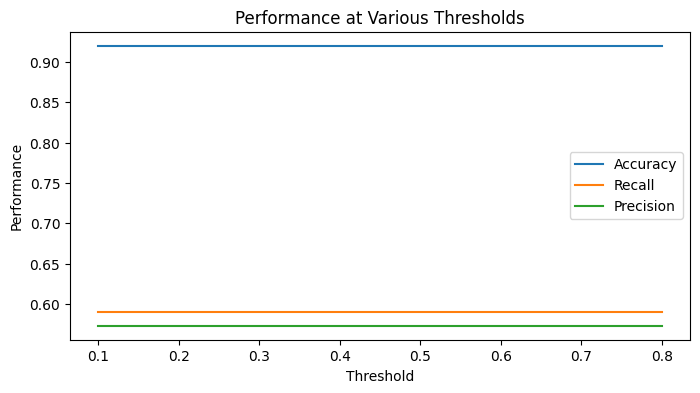

In [49]:
# 提取性能数据
thresholds, accuracies, recalls, precisions = zip(*results)

# 绘图
plt.figure(figsize=(8, 4))
plt.plot(thresholds, accuracies, label='Accuracy')
plt.plot(thresholds, recalls, label='Recall')
plt.plot(thresholds, precisions, label='Precision')
plt.title('Performance at Various Thresholds')
plt.xlabel('Threshold')
plt.ylabel('Performance')
plt.legend()
plt.show()

从结果来看，几个指都没有发生变化，尝试找出原因。

In [50]:
print("Unique probability scores:", np.unique(y_probs))

Unique probability scores: [0. 1.]


理论上来讲，这些概率应该在0和1之间变化。但是，实际上概率值只有0和1两种情况，这说明了决策树完全的将样本分为了0或者1，也就是发生了过拟合。

我们尝试打印出来这个树的深度：

In [51]:
# 计算树的实际深度
tree_depth = tree_model.get_depth()
# 打印决策树的实际深度
print("Tree depth:", tree_depth)

Tree depth: 85


可以发现，这个决策树的深度过深，在没有指定参数的情况之下，达到了85层，以至于模型发生了过拟合。

现在尝试限制树的深度，并且进行可视化来找出一个最佳的深度参数：

In [54]:
depths = range(5, 85, 5)  # 从5到80，每次增加5
auc_scores = []

for depth in depths:
    tree_model = DecisionTreeClassifier(max_depth=depth, random_state=42)
    tree_model.fit(X_train, y_train)
    y_probs = tree_model.predict_proba(X_test)[:, 1]  # 获取类别1的概率

    auc_score = roc_auc_score(y_test, y_probs)
    auc_scores.append(auc_score)

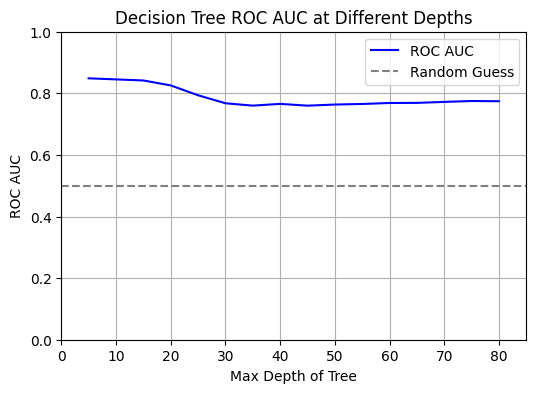

In [55]:
plt.figure(figsize=(6, 4))

# 绘制ROC AUC曲线
plt.plot(depths, auc_scores, label='ROC AUC', color='blue')

# 添加表示随机猜测的对角线
plt.axhline(y=0.5, color='gray', linestyle='--', label='Random Guess')

plt.title('Decision Tree ROC AUC at Different Depths')
plt.xlabel('Max Depth of Tree')
plt.ylabel('ROC AUC')

# 设置x轴和y轴的范围，从(0, 0)开始
plt.xlim([0, max(depths) + 5])  # 加5是为了确保x轴有足够的空间显示最后一个点
plt.ylim([0, 1])  # AUC的范围从0到1

plt.legend()
plt.grid(True)
plt.show()

基于上述的可视化结果，可以认为当max_depth为5的时候，模型的表现是最好的。

In [56]:
# 创建决策树分类器实例，并设置max_depth
tree_model = DecisionTreeClassifier(max_depth=5, random_state=42)
# 训练模型
tree_model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5, random_state=42)

Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.98     27373
           1       1.00      0.54      0.70      2850

    accuracy                           0.96     30223
   macro avg       0.98      0.77      0.84     30223
weighted avg       0.96      0.96      0.95     30223

Confusion Matrix:
[[27368     5]
 [ 1315  1535]]
ROC AUC Score:
0.8486475019243575


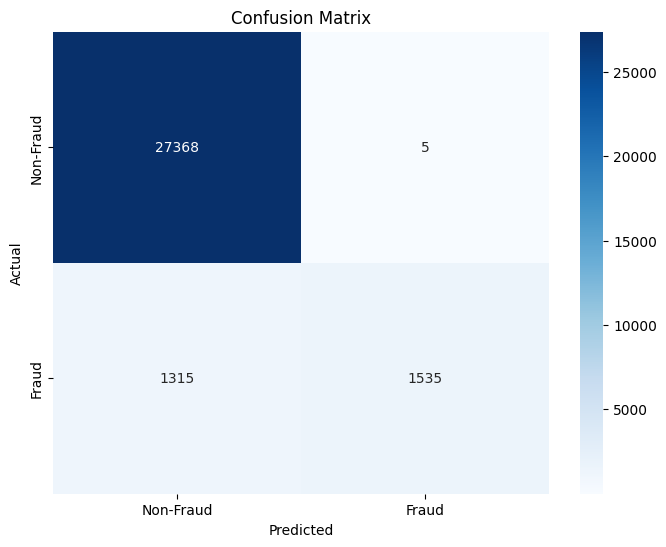

In [57]:
# 在测试集上进行预测
y_pred = tree_model.predict(X_test)
y_probs = tree_model.predict_proba(X_test)[:, 1]  # 获取类别1的概率

# 计算性能指标
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("ROC AUC Score:")
print(roc_auc_score(y_test, y_probs))

# 可视化混淆矩阵
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

在评估模型在测试数据上的表现时，我们可以从分类报告中得到一些关键的洞察。首先，模型的整体准确率达到了96%，这是一个非常高的数字，表明模型在大多数情况下都能正确地分类样本。

在类别层面，非欺诈（类别0）的表现非常出色，精确度达到了95%，这意味着模型预测为非欺诈的样本中有95%是正确的。同时，召回率也达到了100%，说明模型能够识别出所有实际为非欺诈的案例。这两者的结合使得非欺诈类别的F1分数高达98%，显示了模型在这一类别上的卓越性能。

然而，欺诈（类别1）类别的表现则不那么理想。尽管精确度达到了100%，表明所有被模型预测为欺诈的样本都是正确的，但召回率只有54%，这意味着有将近一半的实际欺诈案例没有被模型识别出来。这导致了欺诈类别的F1分数只有70%，远低于非欺诈类别。

这种性能差异提示我们，尽管模型在大多数情况下都能做出正确的预测，但在识别欺诈行为方面还有很大的提升空间。为了提高模型的实用性，特别是在防欺诈系统中，提高对欺诈的召回率可能比保持高准确率更为重要。这可能需要我们调整模型的分类阈值，改进特征工程，或者尝试使用其他算法，如随机森林或梯度提升机，来提高对欺诈行为的检测能力。

此外，考虑到欺诈行为的严重性，我们可能需要采取成本敏感的学习策略，或者调整模型的损失函数，以增加对欺诈类别错误分类的惩罚。这样的策略可以帮助模型更加重视正确识别欺诈案例，即使这可能会稍微降低模型的整体精确度。

总的来说，虽然模型在识别非欺诈交易方面表现出色，但在识别欺诈行为方面还有改进的余地。通过采取适当的策略和技术，我们可以提高模型对欺诈行为的识别能力，从而更有效地防止欺诈活动。

**调整阈值**

In [58]:
# 获取欺诈概率
y_probs = tree_model.predict_proba(X_test)[:, 1]

In [59]:
y_probs

array([0.02721445, 0.03138003, 0.03138003, ..., 0.03138003, 0.02721445,
       0.03138003])

默认是0.5，开始不断的调整：

In [60]:
# 定义一个较低的阈值
threshold = 0.25  # 或者其他更低的值，根据需要调整

# 根据新阈值生成预测
y_pred_new_threshold = (y_probs >= threshold).astype(int)

# 评估新的预测结果
print(classification_report(y_test, y_pred_new_threshold))

              precision    recall  f1-score   support

           0       0.95      1.00      0.98     27373
           1       0.99      0.54      0.70      2850

    accuracy                           0.96     30223
   macro avg       0.97      0.77      0.84     30223
weighted avg       0.96      0.96      0.95     30223



并没有发生什么变化，再往下降：

In [69]:
# 定义一个较低的阈值
threshold = 0.20  # 或者其他更低的值，根据需要调整

# 根据新阈值生成预测
y_pred_new_threshold = (y_probs >= threshold).astype(int)

# 评估新的预测结果
print(classification_report(y_test, y_pred_new_threshold))

              precision    recall  f1-score   support

           0       0.97      0.94      0.96     27373
           1       0.56      0.72      0.63      2850

    accuracy                           0.92     30223
   macro avg       0.77      0.83      0.79     30223
weighted avg       0.93      0.92      0.93     30223



可以发现recall的值有着较大的提升，当然precision的值也发生了下降。

In [73]:
from sklearn.tree import plot_tree

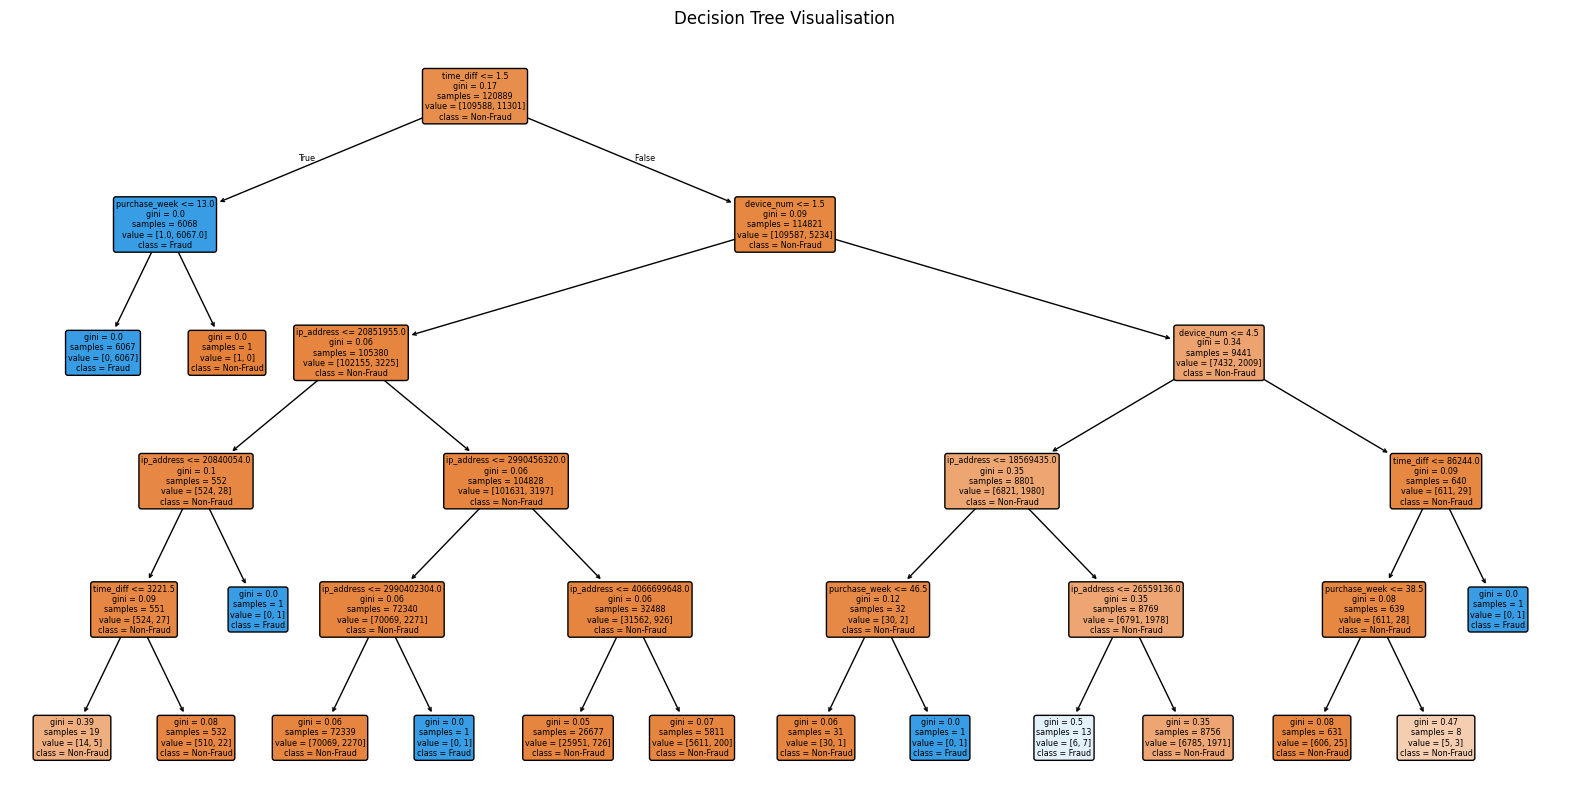

In [74]:
plt.figure(figsize=(20,10))
plot_tree(tree_model, 
          filled=True, 
          class_names=["Non-Fraud", "Fraud"],
          feature_names=X.columns, 
          proportion=False, 
          precision=2,
          rounded=True)
plt.title("Decision Tree Visualisation")
plt.show()

In [72]:
# 定义一个较低的阈值
threshold = 0.10  # 或者其他更低的值，根据需要调整

# 根据新阈值生成预测
y_pred_new_threshold_10 = (y_probs >= threshold).astype(int)

# 评估新的预测结果
print(classification_report(y_test, y_pred_new_threshold_10))

              precision    recall  f1-score   support

           0       0.97      0.94      0.96     27373
           1       0.56      0.72      0.63      2850

    accuracy                           0.92     30223
   macro avg       0.77      0.83      0.79     30223
weighted avg       0.93      0.92      0.93     30223



并没有发生什么改变，所以threshold = 0.2被认为是最终的结果。

在调整决策树模型的阈值至0.2后，我们观察到模型在欺诈检测（类别1）方面的表现有了显著的提升，尤其是在召回率这一关键指标上。具体来看，类别0（非欺诈）的精确度达到了97%，这表明模型在预测非欺诈交易时的可靠性非常高。尽管召回率略有下降至94%，这可能是由于一些非欺诈案例被错误地标记为欺诈，但整体上，模型在非欺诈类别上的表现依然出色，F1分数为96%。

对于类别1（欺诈），调整后的精确度为56%，这意味着在所有被模型标记为欺诈的交易中，有56%实际上是欺诈的。虽然这个比例低于之前的设置，但它揭示了模型现在能够识别出更多的实际欺诈案例，召回率提升至72%。这表明模型的敏感性得到了增强，能够捕捉到更多的欺诈行为。然而，这也导致了F1分数的下降至63%，这主要是由于精确度的降低。

在整体性能方面，模型的准确率下降至92%，虽然较之前的96%有所减少，但这种下降是为了提高对欺诈行为的检测能力，这在防欺诈系统中通常更为关键。在实际应用中，这种权衡可能是合理的，尤其是当欺诈交易的潜在损失远大于误标正常交易的成本时。